In [1]:
%matplotlib inline
import time
import random
from random import shuffle
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import itertools
import logging

import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import transforms, datasets, models
from torchvision.datasets import CIFAR10

from scipy.stats import entropy, ks_2samp
from scipy.special import kl_div
from sklearn import metrics
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import label_binarize

from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

import traceback
import copy

In [2]:
logname = 'logs/decentralized_multi_agent'
logging.basicConfig(filename=logname,
                            filemode='a',
                            format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                            datefmt='%H:%M:%S',
                            level=logging.DEBUG)

logging.info("Running Decentralized Learning test")

logger = logging.getLogger('Decentralized_log')

In [3]:
# reproduce randomness for fair comparison
np.random.seed(0)
torch.manual_seed(21)

In [4]:
# Standard transformations for improving CIFAR10. 

# Transformations A
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Transformations B
RC   = transforms.RandomCrop(32, padding=4)
RHF  = transforms.RandomHorizontalFlip()
RVF  = transforms.RandomVerticalFlip()
NRM  = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
TT   = transforms.ToTensor()
TPIL = transforms.ToPILImage()

# Transforms object for trainset with augmentation
transform_with_aug = transforms.Compose([TPIL, RC, RHF, TT, NRM])
# Transforms object for testset with NO augmentation
transform_no_aug   = transforms.Compose([TT, NRM])

# Downloading/Louding CIFAR10 data
trainset = torchvision.datasets.CIFAR10(root='../data/cifar10', train=True,
                                        download=True, transform=transform_with_aug)

testset = torchvision.datasets.CIFAR10(root='../data/cifar10', train=False,
                                       download=True, transform=transform_no_aug)

classDict = {'plane':0, 'car':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}

# Separating trainset/testset data/label
x_train  = trainset.data
x_test   = testset.data
y_train  = trainset.targets
y_test   = testset.targets

# Define a function to separate CIFAR classes by class index

def get_class_i(x, y, i):
    """
    x: trainset.train_data or testset.test_data
    y: trainset.train_labels or testset.test_labels
    i: class label, a number between 0 to 9
    return: x_i
    """
    # Convert to a numpy array
    y = np.array(y)
    # Locate position of labels that equal to i
    pos_i = np.argwhere(y == i)
    # Convert the result into a 1-D list
    pos_i = list(pos_i[:,0])
    # Collect all data that match the desired label
    x_i = [x[j] for j in pos_i]
    
    return x_i

class DatasetMaker(Dataset):
    def __init__(self, datasets, transformFunc = transform_no_aug):
        """
        datasets: a list of get_class_i outputs, i.e. a list of list of images for selected classes
        """
        self.datasets = datasets
        self.lengths  = [len(d) for d in self.datasets]
        self.transformFunc = transformFunc
    def __getitem__(self, i):
        class_label, index_wrt_class = self.index_of_which_bin(self.lengths, i)
        img = self.datasets[class_label][index_wrt_class]
        img = self.transformFunc(img)
        return img, class_label

    def __len__(self):
        return sum(self.lengths)
    
    def index_of_which_bin(self, bin_sizes, absolute_index, verbose=False):
        """
        Given the absolute index, returns which bin it falls in and which element of that bin it corresponds to.
        """
        # Which class/bin does i fall into?
        accum = np.add.accumulate(bin_sizes)
        if verbose:
            print("accum =", accum)
        bin_index  = len(np.argwhere(accum <= absolute_index))
        if verbose:
            print("class_label =", bin_index)
        # Which element of the fallent class/bin does i correspond to?
        index_wrt_class = absolute_index - np.insert(accum, 0, 0)[bin_index]
        if verbose:
            print("index_wrt_class =", index_wrt_class)

        return bin_index, index_wrt_class

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [5]:
x_train.shape

(50000, 32, 32, 3)

In [6]:
# If we are saving a fraction of random data to be used in training
frac = int(len(x_train) * 0.05)
x_reserve = x_train[:frac]
y_reserve = y_train[:frac]
x_train = x_train[frac:]
y_train = y_train[frac:]

In [7]:
# ================== Usage ================== #

# 
trainset1 = \
    DatasetMaker(
        [get_class_i(x_train, y_train, classDict['plane']), 
         get_class_i(x_train, y_train, classDict['car']), 
         get_class_i(x_train, y_train, classDict['bird']),
        [],[],[],[],[],[],[]],
        transform_with_aug
    )
trainset2 = \
    DatasetMaker(
        [[],[],[],
         get_class_i(x_train, y_train, classDict['cat']), 
         get_class_i(x_train, y_train, classDict['deer']), 
         get_class_i(x_train, y_train, classDict['dog']), 
         [],[],[],[]],
        transform_with_aug
    )
trainset3 = \
    DatasetMaker(
        [[],[],[],[],[],[],
         get_class_i(x_train, y_train, classDict['frog']), 
         get_class_i(x_train, y_train, classDict['horse']), 
         get_class_i(x_train, y_train, classDict['ship']), 
         get_class_i(x_train, y_train, classDict['truck'])],
        transform_with_aug
    )
trainset4 = \
    DatasetMaker(
        [get_class_i(x_train, y_train, classDict['plane']), 
         get_class_i(x_train, y_train, classDict['car']), 
         get_class_i(x_train, y_train, classDict['bird']), 
         get_class_i(x_train, y_train, classDict['cat']), 
         get_class_i(x_train, y_train, classDict['deer']),
         get_class_i(x_train, y_train, classDict['dog']), 
         get_class_i(x_train, y_train, classDict['frog']), 
         get_class_i(x_train, y_train, classDict['horse']), 
         get_class_i(x_train, y_train, classDict['ship']), 
         get_class_i(x_train, y_train, classDict['truck'])],
        transform_with_aug
    )
reserved = \
    DatasetMaker(
        [get_class_i(x_reserve, y_reserve, classDict['plane']), 
         get_class_i(x_reserve, y_reserve, classDict['car']), 
         get_class_i(x_reserve, y_reserve, classDict['bird']), 
         get_class_i(x_reserve, y_reserve, classDict['cat']), 
         get_class_i(x_reserve, y_reserve, classDict['deer']),
         get_class_i(x_reserve, y_reserve, classDict['dog']), 
         get_class_i(x_reserve, y_reserve, classDict['frog']), 
         get_class_i(x_reserve, y_reserve, classDict['horse']), 
         get_class_i(x_reserve, y_reserve, classDict['ship']), 
         get_class_i(x_reserve, y_reserve, classDict['truck'])],
        transform_with_aug
    )
testset  = \
    DatasetMaker(
        [get_class_i(x_test, y_test, classDict['plane']), 
         get_class_i(x_test, y_test, classDict['car']), 
         get_class_i(x_test, y_test, classDict['bird']), 
         get_class_i(x_test, y_test, classDict['cat']), 
         get_class_i(x_test, y_test, classDict['deer']),
         get_class_i(x_test, y_test, classDict['dog']), 
         get_class_i(x_test, y_test, classDict['frog']), 
         get_class_i(x_test, y_test, classDict['horse']), 
         get_class_i(x_test, y_test, classDict['ship']), 
         get_class_i(x_test, y_test, classDict['truck'])],
        transform_no_aug
    )

superset = torch.utils.data.ConcatDataset([trainset3,reserved])
supersetA = torch.utils.data.ConcatDataset([trainset1,reserved])
supersetB = torch.utils.data.ConcatDataset([trainset2,reserved])

kwargs = {'num_workers': 2, 'pin_memory': False}

# Create datasetLoaders from trainset and testset
trainsetLoader1   = DataLoader(trainset1, batch_size=128, shuffle=True , **kwargs)
trainsetLoader2   = DataLoader(trainset2, batch_size=128, shuffle=True , **kwargs)
trainsetLoader3   = DataLoader(trainset3, batch_size=128, shuffle=True , **kwargs)
trainsetLoader4   = DataLoader(trainset4, batch_size=128, shuffle=True , **kwargs)
reservedLoader    = DataLoader(superset, batch_size=128, shuffle=True , **kwargs)
reservedLoaderA    = DataLoader(supersetA, batch_size=128, shuffle=True , **kwargs)
reservedLoaderB    = DataLoader(supersetB, batch_size=128, shuffle=True , **kwargs)
testsetLoader     = DataLoader(testset , batch_size=128, shuffle=False, **kwargs)

In [8]:
def imshow(img):
    img = img / 2 + 0.3    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#### Test that things are working

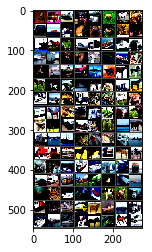

In [9]:
img, label = next(iter(reservedLoader))
imshow(torchvision.utils.make_grid(img))

In [10]:
img.shape

torch.Size([128, 3, 32, 32])

#### Decide on a GPU to use

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
print(device)

# device2 = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

cuda:0


# Decentralized Pairwise Knowledge Transfer

## Define models used in knowledge transfer

In [12]:
def kaiming_init(m):
    if isinstance(m, (torch.nn.Linear)):
        torch.nn.init.sparse_(m.weight, sparsity=0.33)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (torch.nn.Conv2d)):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)

class Decenter(torch.nn.Module):

    def __init__(self, shape):
        super(Decenter, self).__init__()
        if len(shape) == 1:
            shape = shape[0]
            self.dim = 0
        elif len(shape) == 2:
            shape = shape[1]
            self.dim = 1
        self.translation = torch.nn.Sequential(
#             torch.nn.Tanh(),
            torch.nn.Linear(shape*3, shape)
        )

#         self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, source1, source2, target):
        x = torch.cat((source1, source2, target), self.dim)
#         x = torch.cat((torch.flatten(source), torch.flatten(target)), 0)
#         x = torch.add(torch.flatten(source).to("cpu"), torch.flatten(target).to("cpu"))
        res = self.translation(x)
#         res = res.reshape(target.shape)
        return res
    
    
class Interpolate(torch.nn.Module):
    def __init__(self, size, mode):
        super(Interpolate, self).__init__()
        self.interp = torch.nn.functional.interpolate
        self.size = size
        self.mode = mode
        
    def forward(self, x):
        x = self.interp(x, size=self.size, mode=self.mode, align_corners=False)
        return x
    
class Reshape(torch.nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)
    
class Decenter_pooled(torch.nn.Module):

    def __init__(self, shape):
        super(Decenter_pooled, self).__init__()
        self.shape = shape
        self.translation = torch.nn.Sequential(
#             torch.nn.BatchNorm2d(channels_out),
#             torch.nn.AdaptiveAvgPool2d(1),
            Interpolate(size=1, mode='bilinear'),
            Reshape(shape[0], shape[1]*2),
            torch.nn.Linear(shape[1]*2, shape[1]*shape[-1]*shape[-1]),
#             Reshape(shape[0], shape[1] ,1 ,1),
        )

#         self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, source, target):
        x = torch.cat((source, target), 1)
        res = self.translation(x)
        res = res.view(self.shape[0], self.shape[1], self.shape[2], self.shape[3])
        return res
    
    
class Decenter_conv(torch.nn.Module):

    def __init__(self, shape):
        super(Decenter_conv, self).__init__()
        self.shape = shape
        channels_in = shape[1]*3
        channels_out = shape[1]
        self.translation = torch.nn.Sequential(
#             torch.nn.BatchNorm2d(channels_in),
            torch.nn.Conv2d(channels_in, channels_out, 1, stride=1, padding=0)
#             torch.nn.ConvTranspose2d(channels_in, channels_out, 3, stride=1, padding=1)
#             torch.nn.Linear(shape[0]*2, shape[0]*4),
#             torch.nn.Dropout(p=0.5),
#             torch.nn.Linear(shape[0]*2, shape[0]),
#             torch.nn.AdaptiveAvgPool2d((shape[-2],shape[-1])),
#             torch.nn.Conv2d(channels_out, channels_out, 3, stride=1, padding=1)

        )
        self.translation2 = torch.nn.Sequential(
            torch.nn.AdaptiveMaxPool2d((shape[-2],shape[-1])),
        )

#         self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, source1, source2, target):
        x = torch.cat((source1, source2, target), 1)
#         x = x.reshape(-1, x.shape[0])
#         x = torch.cat((torch.flatten(source), torch.flatten(target)), 0)
#         x = torch.add(torch.flatten(source).to("cpu"), torch.flatten(target).to("cpu"))
        res = self.translation(x)
#         res = res.reshape(self.shape)
        return res

class Special(torch.nn.Module):
    def __init__(self):
        super(Special, self).__init__()
        self.w1 = torch.nn.Parameter(torch.tensor(0.3333333))
        self.w2 = torch.nn.Parameter(torch.tensor(0.3333333))
        self.w3 = torch.nn.Parameter(torch.tensor(0.3333333))
        
    def forward(self, source1, source2, target, x):
        s1 = copy.deepcopy(source1.state_dict())
        s2 = copy.deepcopy(source2.state_dict())
        t = copy.deepcopy(target.state_dict())
        
        w_glob = copy.deepcopy(t)
        for k in mdlzAC.keys():
            w_glob[k] = s1[k]*self.w1+s2[k]*self.w2+t[k]*self.w3
#         target.load_state_dict(w_glob)
        
        return w_glob

## Define the local training process

In [13]:
import pdb
### Hooks are used to investigate the effect of gradiant decent on weights. Not necessary for simply reproducing paper results. 
grad_dict: dict = {}
def fc_hook(layer_name, grad_input, grad_output): 
    if layer_name not in grad_dict:
        grad_dict[layer_name] = {}
        grad_dict[layer_name]["grad_input"] = []
        grad_dict[layer_name]["grad_output"] = []
        grad_dict[layer_name]["labels"] = []
        
#     print(grad_input)
#     print(grad_output)
    grad_dict[layer_name]["grad_input"].append(grad_input[0].cpu().numpy())
    grad_dict[layer_name]["grad_output"].append(grad_output[0].cpu().numpy())
    
# def reserve_step(source, target):
    

matlst = []
fclst = []

## Option are used for simulating remote agents using pairwise knowledge transfer 
options = {0: ['trainA', 'validA','reservedAB'], 
           1: ['trainB','validB','reservedBA'],
           2: ['trainC','validC','reservedCA','validC']}

dtype = torch.float

def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):

    writer = SummaryWriter('runs/') 

    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = 0.0
    best_acc = 0.0
    dataset_sizes = {'trainA': len(dataloders['trainA'].sampler),
                     'trainB': len(dataloders['trainB'].sampler),
                     'trainC': len(dataloders['trainC'].sampler),
                     'reservedA': len(dataloders['reservedA'].sampler),
                     'reservedB': len(dataloders['reservedB'].sampler),
                     'reservedCA': len(dataloders['reservedCA'].sampler),
                     'reservedAB': len(dataloders['reservedAB'].sampler),
                     'reservedBA': len(dataloders['reservedBA'].sampler),
                     'validA': len(dataloders['validA'].sampler),
                     'validB': len(dataloders['validB'].sampler),
                     'validC': len(dataloders['validC'].sampler)}

    i = z = 0
    ivc = 0
    for epoch in range(num_epochs):
        for phase in ['trainA', 'validA','trainB','validB','trainC','validC','reservedCA','validC']:  ## this sequense simualtes a half mesh configuation
#         choice = np.random.choice(range(3), replace=False)
#         for phase in options[choice]:
            if phase not in ['validA','validB','validC']:
                model[phase].train(True)
            else:
                model['trainA'].train(False)
                model['trainB'].train(False)
                model['trainC'].train(False)
            
            
            running_loss = 0.0
            running_corrects = 0        
                    
            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer[phase].zero_grad()
                
                ## if its a transfer phase, swap layers using the pipline models
#                 if phase in ['reservedCA','reservedAB', 'reservedBA']:
                if phase == 'reservedCA':
                        sd = model[phase].state_dict()
                        for key, value in mdlzAC.items():
                            shape = model['trainC'].state_dict()[key].shape
                            mdl = value[1](shape).to(device)
                            checkpoint = torch.load(value[0])
                            mdl.load_state_dict(checkpoint['model_state_dict'])
                            mdl.eval()
                            sd[key] = mdl(copy.deepcopy(model['trainA'].state_dict()[key]),
                                          copy.deepcopy(model['trainB'].state_dict()[key]),
                                          copy.deepcopy(model['trainC'].state_dict()[key]))
    #                         torch.save({'model_state_dict': mdl.state_dict()}, value[0])

    #                         if key == 'conv1.weight':
    #                             matlst.append(sd[key])
    #                         elif key == 'fc.weight':
    #                             fclst.append(sd[key])
                        model[phase].load_state_dict(sd)
        
                #print(list(model[phase].parameters()))
                outputs = model[phase](inputs)
                _, preds = torch.max(outputs.data, 1)
                
                ## if its a transfer phase, compute remote loss term
                if phase in ['reservedCA','reservedAB','reservedBA']:
                    loss_a = criterion['trainC'](outputs, labels)
#                     batch_size = labels.shape[0]
#                     # Dummy input that HAS to be 2D for the scatter (you can use view(-1,1) if needed)
#                     y = labels.reshape(-1,1)
#                     # One hot encoding buffer that you create out of the loop and just keep reusing
#                     y_onehot = torch.FloatTensor(batch_size, 10).to(device)

#                     # In your for loop
#                     y_onehot.zero_()
#                     y_onehot.scatter_(1, y, 1)

                    if phase == 'reservedCA':
                        outputs2 = model['trainA'](inputs)
                        outputs3 = model['trainB'](inputs)
                    elif phase == 'reservedAB':
                        outputs2 = model['trainC'](inputs)
                        outputs3 = model['trainB'](inputs)
                    elif phase == 'reservedBA':
                        outputs2 = model['trainC'](inputs)
                        outputs3 = model['trainA'](inputs)
    
#                     sm = torch.nn.Softmax(dim=1)
                    sm = torch.nn.LogSoftmax(dim=1)
                    outputs = sm(outputs)
                    outputs2 = sm(outputs2)
                    outputs3 = sm(outputs3)
                    loss_b = criterion[phase](outputs, outputs2)
                    loss_c = criterion[phase](outputs, outputs3)
#                     loss = (loss_a + (loss_b + loss_c)*0.5)*0.5

                    loss_d = criterion[phase](sd['fc.weight'], model['trainA'].state_dict()['fc.weight'])
                    loss_e = criterion[phase](sd['fc.weight'], model['trainB'].state_dict()['fc.weight'])
                    loss = (loss_a*0.3333333 + (loss_b + loss_c)*0.33333333 + (loss_d + loss_e)*0.33333333)
                    
                ## if its not a transfer phase, compute local loss term
                else:
                    loss = criterion[phase](outputs, labels)

                ## if its not a validation phase, optimize our models
                if phase not in ['validA','validB','validC']:
                    loss.backward()
                    if phase == 'reservedCA':
#                       loss_b.backward(retain_graph=False)
                        for key, value in mdlzAC.items():
                            shape = model['trainC'].state_dict()[key].shape
                            mdl = value[1](shape).to(device)
                            opti = torch.optim.AdamW(mdl.parameters(), lr=0.01, betas=(0.9, 0.999))
                            checkpoint = torch.load(value[0])
                            mdl.load_state_dict(checkpoint['model_state_dict'])
                            mdl.train(True)
                            opti.load_state_dict(checkpoint['optimizer_state_dict'])
#                             opti.zero_grad()
                            opti.step()
                            torch.save({'model_state_dict': mdl.state_dict(),
                                        'optimizer_state_dict': opti.state_dict(),
                                        'factor': checkpoint['factor'],
                                        'patience': checkpoint['patience'],
                                        'scheduler_state_dict': checkpoint['scheduler_state_dict']},
                                        value[0])
                    else:
                        optimizer[phase].step()
                            
                    
                    ## Back prop hook
#                     grad_dict["fc"]["labels"].append(labels.cpu().numpy())

                
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            ## update scheduler for each model
            if phase in ['validA','validB','validC']:
                scheduler[phase].step(running_loss)
                
            elif phase == 'reservedCA':
                for key, value in mdlzAC.items():
                    checkpoint = torch.load(value[0])
                    sched = lr_scheduler.ReduceLROnPlateau(optimizerC, 'min', factor=checkpoint['factor'], patience=checkpoint['patience'])
                    sched.load_state_dict(checkpoint['scheduler_state_dict'])
                    sched.step(running_loss)
                    torch.save({'model_state_dict': checkpoint['model_state_dict'],
                                'optimizer_state_dict': checkpoint['optimizer_state_dict'],
                                'factor': checkpoint['factor'],
                                'patience': checkpoint['patience'],
                                'scheduler_state_dict': sched.state_dict()},
                                value[0])

#             elif phase == 'reservedAB':
#                 for key, value in mdlzAB.items():
#                     checkpoint = torch.load(value[0])
#                     sched = lr_scheduler.ReduceLROnPlateau(optimizerA, 'min', factor=checkpoint['factor'], patience=checkpoint['patience'])
#                     sched.load_state_dict(checkpoint['scheduler_state_dict'])
#                     sched.step(running_loss)
#                     torch.save({'model_state_dict': checkpoint['model_state_dict'],
#                                 'optimizer_state_dict': checkpoint['optimizer_state_dict'],
#                                 'factor': checkpoint['factor'],
#                                 'patience': checkpoint['patience'],
#                                 'scheduler_state_dict': sched.state_dict()},
#                                 value[0])
                    
#             elif phase == 'reservedBA':
#                 for key, value in mdlzBA.items():
#                     checkpoint = torch.load(value[0])
#                     sched = lr_scheduler.ReduceLROnPlateau(optimizerB, 'min', factor=checkpoint['factor'], patience=checkpoint['patience'])
#                     sched.load_state_dict(checkpoint['scheduler_state_dict'])
#                     sched.step(running_loss)
#                     torch.save({'model_state_dict': checkpoint['model_state_dict'],
#                                 'optimizer_state_dict': checkpoint['optimizer_state_dict'],
#                                 'factor': checkpoint['factor'],
#                                 'patience': checkpoint['patience'],
#                                 'scheduler_state_dict': sched.state_dict()},
#                                 value[0])

                
            ## report results
            if phase not in ['validA','validB','validC']:
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects.double() / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print('Epoch [{}/{}] phase: {} train loss: {:.4f} acc: {:.4f} ' 
                      'valid loss: {:.4f} acc: {:.4f}'.format(
                        epoch, num_epochs - 1,
                        phase,
                        train_epoch_loss, train_epoch_acc, 
                        valid_epoch_loss, valid_epoch_acc))
                print() 
                logger.info('Epoch [{}/{}] phase: {} train loss: {:.4f} acc: {:.4f} ' 
                      'valid loss: {:.4f} acc: {:.4f}'.format(
                        epoch, num_epochs - 1,
                        phase,
                        train_epoch_loss, train_epoch_acc, 
                        valid_epoch_loss, valid_epoch_acc))
                
                ## Writing to tensorboard
                if phase == 'validC':
                    ivc += 1
                    if ivc == 2:
                        writer.add_histogram('distribution centers/our_half_mesh_transfer', outputs, i)

                        writer.add_scalar('train/loss_our_half_mesh_tansfer', train_epoch_loss, epoch)
                        writer.add_scalar('train/accuracy_our_half_mesh_tansfer', train_epoch_acc, epoch)

                        writer.add_scalar('valid/loss_our_half_mesh_tansfer', valid_epoch_loss, epoch)
                        writer.add_scalar('valid/accuracy_our_half_mesh_tansfer', valid_epoch_acc, epoch)
                        ivc = 0

                
            if phase in ['validC'] and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model[phase].state_dict()

            i+=1
    print('Best val Acc: {:4f}'.format(best_acc))
    logger.info('Best val Acc: {:4f}'.format(best_acc))

    writer.close()
    model['validC'].load_state_dict(best_model_wts)
    return model

In [14]:
## Define models for network of learners, optimizers, and loss terms

resnetA = models.resnet50(pretrained=True)
resnetB = models.resnet50(pretrained=True)
resnetC = models.resnet50(pretrained=True)
# freeze all model parameters
# for param in resnet.parameters():
#     param.requires_grad = False

# new final layer with 10 classes
num_ftrsA = resnetA.fc.in_features
resnetA.fc = torch.nn.Linear(num_ftrsA, 10)

num_ftrsB = resnetB.fc.in_features
resnetB.fc = torch.nn.Linear(num_ftrsB, 10)

num_ftrsC = resnetC.fc.in_features
resnetC.fc = torch.nn.Linear(num_ftrsC, 10)

def fc_backward_hook(module, grad_input, grad_output):  # module is Linear in this case. Ignored.
        fc_hook("fc", grad_input, grad_output)
resnetA.fc_hook_handle = resnetA.fc.register_backward_hook(fc_backward_hook)
resnetB.fc_hook_handle = resnetB.fc.register_backward_hook(fc_backward_hook)
resnetC.fc_hook_handle = resnetC.fc.register_backward_hook(fc_backward_hook)


def roc_auc_score_micro(y_pred_proba, y_true):
    y_pred_proba = y_pred_proba.detach().cpu()
    y_true = y_true.detach().cpu()
    return metrics.roc_auc_score(
        label_binarize(y_true, classes=list(range(y_pred_proba.shape[1]))).ravel(),
        y_pred_proba.flatten())


resnetA = resnetA.to(device)
resnetB = resnetB.to(device)
resnetC = resnetC.to(device)

criterionA = torch.nn.CrossEntropyLoss()
# criterionB = torch.nn.CrossEntropyLoss()
# criterionA = torch.nn.KLDivLoss()
criterionB = torch.nn.KLDivLoss(reduction = 'batchmean')
# criterionB = torch.nn.KLDivLoss(reduction = 'mean')
# criterionB = torch.nn.MSELoss()
optimizerA = torch.optim.SGD(resnetA.parameters(), lr=0.01, momentum=0.9)
optimizerB = torch.optim.SGD(resnetB.parameters(), lr=0.01, momentum=0.9)
optimizerC = torch.optim.SGD(resnetC.parameters(), lr=0.01, momentum=0.9)
# optimizerA = torch.optim.AdamW(resnetA.parameters(), lr=0.01, betas=(0.9, 0.999))
# optimizerB = torch.optim.AdamW(resnetB.parameters(), lr=0.01, betas=(0.9, 0.999))
# optimizerC = torch.optim.AdamW(resnetC.parameters(), lr=0.01, betas=(0.9, 0.999))

# exp_lr_schedulerA = lr_scheduler.StepLR(optimizerA, step_size=5, gamma=0.01)
# exp_lr_schedulerB = lr_scheduler.StepLR(optimizerB, step_size=5, gamma=0.01)
# exp_lr_schedulerC = lr_scheduler.StepLR(optimizerC, step_size=5, gamma=0.2)
exp_lr_schedulerA = lr_scheduler.ReduceLROnPlateau(optimizerA, 'min', factor=0.90, patience=500)
exp_lr_schedulerB = lr_scheduler.ReduceLROnPlateau(optimizerB, 'min', factor=0.90, patience=500)
exp_lr_schedulerC = lr_scheduler.ReduceLROnPlateau(optimizerC, 'min', factor=0.90, patience=500)


def hwout(Hin, padding, dilation, kernel_size, stride):
    return (Hin + 2 * padding - dilation * (kernel_size-1) - 1)/stride + 1

KeyboardInterrupt: 

In [ ]:
## Function for finding largest layer

max_layer = 0
max_neurons = 0
for prm in resnetC.named_parameters():
    num_ftr = np.prod(prm[1].shape)
    if num_ftr > max_neurons:
         max_neurons = num_ftr
         max_layer = prm[1]

In [ ]:
[x[0] for x in resnetC.named_parameters()]

In [ ]:
# %%timeit
### Define our transfer pipeline and attach models, and parameters. Model chains are saved to disk for memory efficient execution.
mdlzAC = dict()
mdlzAB = dict()
mdlzBA = dict()
params = []
model_dir = './multi_model_chain'
conv_layers = []
bn_layers = ['fc.weight']

for prm in resnetC.named_parameters():
# for prm in temp_list:
#     if 'conv' in prm[0] or 'fc' in prm[0] or 'bn' in prm[0] or 'downsample' in prm[0]:
    if prm[0] in bn_layers+conv_layers:
#     if 'conv' in prm[0] or 'fc' in prm[0]:
        try:
#             mdl = Special().to(device)
            if prm[1].dim() > 2:
#                 if prm[0] not in conv_layers:
#                     continue
                mdl = Decenter_conv(prm[1].shape).to(device)
                optimizer = torch.optim.AdamW(mdl.parameters(), lr=0.01, betas=(0.9, 0.999))
                exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=900)
                torch.save({'model_state_dict': mdl.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'factor': 0.1,
                            'patience': 900,
                            'scheduler_state_dict': exp_lr_scheduler.state_dict()},
                           model_dir + '/' + prm[0]+'A')
                torch.save({'model_state_dict': mdl.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'factor': 0.1,
                            'patience': 900,
                            'scheduler_state_dict': exp_lr_scheduler.state_dict()},
                           model_dir + '/' + prm[0]+'B')
                torch.save({'model_state_dict': mdl.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'factor': 0.1,
                            'patience': 900,
                            'scheduler_state_dict': exp_lr_scheduler.state_dict()},
                           model_dir + '/' + prm[0]+'C')
#                 mdlzAC[prm[0]] = (mdl, optimizer, exp_lr_scheduler)
                mdlzAC[prm[0]] = (model_dir + '/' + prm[0]+'A', Decenter_conv)
#                 params += mdl.parameters()
#                 pass
            else:
#                 if prm[0] not in bn_layers:
#                     continue
                mdl = Decenter(prm[1].shape).to(device)
                optimizer = torch.optim.AdamW(mdl.parameters(), lr=0.01, betas=(0.9, 0.999))
                exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=900)
                torch.save({'model_state_dict': mdl.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'factor': 0.5,
                            'patience': 900,
                            'scheduler_state_dict': exp_lr_scheduler.state_dict()},
                           model_dir + '/' + prm[0]+'A')
                torch.save({'model_state_dict': mdl.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'factor': 0.5,
                            'patience': 900,
                            'scheduler_state_dict': exp_lr_scheduler.state_dict()},
                           model_dir + '/' + prm[0]+'B')
                torch.save({'model_state_dict': mdl.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'factor': 0.5,
                            'patience': 900,
                            'scheduler_state_dict': exp_lr_scheduler.state_dict()},
                           model_dir + '/' + prm[0]+'C')
                mdlzAC[prm[0]] = (model_dir + '/' + prm[0]+'A', Decenter)
#                 params += mdl.parameters()
            
            del mdl
            torch.cuda.empty_cache()
        except Exception as e:
            print("Problem with: " + prm[0] + " Size: " + str(num_ftr))
            print("Error: " + str(e))
            traceback.print_exc()
            print()
            pass
        
# params += list(resnetC.parameters())

# optimizerRB = torch.optim.SGD(params, lr=0.01, momentum=0.9)
# mdlAC = Special().to(device)
# optimizerAC = torch.optim.AdamW(mdlAC.parameters(), lr=0.01, betas=(0.9, 0.999))
# exp_lr_schedulerAC = lr_scheduler.ReduceLROnPlateau(optimizerAC, 'min', factor=0.1, patience=900)
# optimizerRC = torch.optim.AdamW(resnetC.parameters(), lr=0.001, betas=(0.9, 0.999))

In [ ]:
mdlzAC

In [ ]:
### Define phases and associated pareameters
dloaders = {'trainA':trainsetLoader1, 'trainB':trainsetLoader2, 'trainC':reservedLoader,
            'validA':testsetLoader, 'validB':testsetLoader, 'validC':testsetLoader,
            'reservedA':reservedLoader, 'reservedB':reservedLoader, 'reservedCA':reservedLoader, 'reservedAB':reservedLoaderA, 'reservedBA':reservedLoaderB}
model = {'trainA':resnetA, 'trainB':resnetB, 'trainC':resnetC,
         'validA':resnetA, 'validB':resnetB, 'validC':resnetC,
         'reservedA':resnetA, 'reservedB':resnetB, 'reservedCA':resnetC, 'reservedAB':resnetA, 'reservedBA':resnetB}
optimizer = {'trainA':optimizerA, 'trainB':optimizerB, 'trainC':optimizerC,
             'validA':optimizerA, 'validB':optimizerB, 'validC':optimizerC,
             'reservedA':optimizerA, 'reservedB':optimizerB, 'reservedCA':optimizerC, 'reservedAB':optimizerA, 'reservedBA':optimizerB}
criterion = {'trainA':criterionA, 'trainB':criterionA, 'trainC':criterionA,
             'validA':criterionA, 'validB':criterionA, 'validC':criterionA,
             'reservedA':criterionB, 'reservedB':criterionB, 'reservedCA':criterionB, 'reservedAB':criterionB, 'reservedBA':criterionB}
exp_lr_scheduler = {'trainA':exp_lr_schedulerA, 'trainB':exp_lr_schedulerB, 'trainC':exp_lr_schedulerC,
             'validA':exp_lr_schedulerA, 'validB':exp_lr_schedulerB, 'validC':exp_lr_schedulerC,
             'reservedA':exp_lr_schedulerA, 'reservedB':exp_lr_schedulerB, 'reservedCA':exp_lr_schedulerC, 'reservedAB':exp_lr_schedulerA, 'reservedBA':exp_lr_schedulerB}

In [ ]:
### Run decentralized pairwised knowledge transfer

logging.info("#### bn acti conv and fc - unlimited bn - adam learning rate 0.001 - scheduler 20 - opt adamw ####")

start_time = time.time()
model = train_model(dloaders, model, criterion, optimizer, exp_lr_scheduler, num_epochs=60)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

## Testing ground - Generate confusion matrices of TP,FP,FN

#### without 5%

In [20]:
confusion_matrix = torch.zeros(10, 10)
for inputs, labels in dloaders['validC']:
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

    outputs = model['validC'](inputs)
    _, preds = torch.max(outputs.data, 1)
    
    for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

In [21]:
print(confusion_matrix)

tensor([[677.,   6.,  37.,  14.,  10.,   3.,  33.,  25., 131.,  64.],
        [ 15., 641.,   2.,   3.,   1.,   2.,  22.,   5.,  55., 254.],
        [ 52.,   0., 488.,  42.,  62.,  40., 206.,  78.,  15.,  17.],
        [ 11.,   1.,  33., 431.,  24., 166., 199.,  82.,  26.,  27.],
        [  9.,   1.,  55.,  67., 535.,  26., 134., 148.,  15.,  10.],
        [  3.,   0.,  32., 121.,  15., 631.,  74.,  98.,  10.,  16.],
        [  2.,   0.,   4.,   4.,   5.,  11., 967.,   1.,   2.,   4.],
        [  5.,   0.,   2.,   8.,   9.,  10.,  11., 942.,   3.,  10.],
        [ 18.,   1.,   3.,   6.,   3.,   0.,  10.,   2., 939.,  18.],
        [  5.,   7.,   0.,   2.,   0.,   1.,   6.,   3.,  15., 961.]])


#### with 5%

In [21]:
confusion_matrix = torch.zeros(10, 10)
for inputs, labels in dloaders['validC']:
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

    outputs = model['validC'](inputs)
    _, preds = torch.max(outputs.data, 1)
    
    for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

In [22]:
print(confusion_matrix)

tensor([[545.,   9.,  35.,   6.,  37.,   0.,  31.,  45., 219.,  73.],
        [  7., 707.,   0.,   0.,   2.,   1.,  13.,   8.,  59., 203.],
        [ 19.,   0., 520.,  21.,  83.,  19., 198.,  88.,  40.,  12.],
        [  5.,   3.,  32., 399.,  52.,  85., 227., 126.,  35.,  36.],
        [  5.,   1.,  30.,  25., 630.,   7., 123., 157.,  13.,   9.],
        [  2.,   1.,  33., 123.,  33., 488., 102., 186.,  14.,  18.],
        [  1.,   1.,   5.,   3.,   5.,   3., 965.,  11.,   2.,   4.],
        [  1.,   0.,   0.,   5.,   6.,   3.,   4., 965.,   6.,  10.],
        [  5.,   3.,   0.,   1.,   3.,   0.,   6.,   1., 969.,  12.],
        [  2.,  10.,   2.,   1.,   0.,   0.,   4.,   6.,  22., 953.]])


### with knowledge transfer

In [25]:
confusion_matrix = torch.zeros(10, 10)
for inputs, labels in dloaders['validC']:
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

    outputs = model['validC'](inputs)
    _, preds = torch.max(outputs.data, 1)
    
    for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

In [26]:
print(confusion_matrix)

tensor([[ 42.,  17.,  30.,  23.,  27.,  26., 186., 157., 268., 224.],
        [ 25.,  49.,  22.,  16.,  11.,  15., 172., 155., 245., 290.],
        [ 39.,  20.,  52.,  28.,  21.,  33., 211., 199., 201., 196.],
        [ 22.,  24.,  20.,  42.,  25.,  39., 198., 177., 228., 225.],
        [ 23.,  13.,  20.,  24.,  32.,  27., 208., 217., 233., 203.],
        [ 20.,  23.,  26.,  25.,  16.,  37., 180., 213., 215., 245.],
        [ 20.,  24.,  23.,  20.,  22.,  15., 310., 152., 215., 199.],
        [ 13.,  15.,  16.,  25.,  21.,  30., 163., 361., 159., 197.],
        [ 15.,  32.,  21.,  25.,  15.,  20., 171., 128., 369., 204.],
        [ 12.,  36.,  21.,  21.,  17.,  14., 182., 153., 196., 348.]])
